<div align='center'><div align='center'>
    
## Image Processing

### Convolution and Edge Detection

#### Version 1.0, 8th Mar, 2022
</div>

### 4.6 Learning Outcomes

1. Appreciating the difference between linear and non-linear operations in edge detection. It is often found that the Prewitt, or similar, masks are called _edge detection_ masks. But they are **not**, and there is no such thing. The masks, applied by convolution, provide _gradient estimates_.

2. Appreciating in a concrete way the steps required to go from a signal (or image) to a measure of gradient strength, and then applying a decision process to create an edge map.

3. Understanding how a derivative operation can be approximated by a finite difference operation, which is really easy to understand!

4. Appreciating that the finite difference operator can be implemented by one dimensional convolution.

5. Getting some confidence in how to interpret the 1D convolution expression, by unravelling the summation into a series of terms.

6. Reminding ourselves that convolution enables flexibility in implementing linear operators: just change the convolution mask to perform a different type of linear neighbourhood operation.

7. Understanding that results of applying a pair of gradient estimation convolution masks is a pair of scalar fields that can be represented as a vector field.

8. Understanding how to approximate a Gaussian convolution by sampling the equation of a continuous Gaussian, and paying attention to a couple of details.

Begin this session by reviewing the Practical on image display and colourmaps; this will be useful to interpret
the results of convolution. 

### 4.1 One-Dimensional Edge Map
Understanding convolution gives you another way to look at the link between classical mathematical ideas and the techniques we regularly use for image, signal and data analysis.

We are going to start with the idea of creating a simple detector on a series of values -- a one-dimensional signal -- in order to detect a substantial change in the values as we move through the signal from one end to the other. This idea can be used to detect sudden changes in the state of something, including in physiological measurements; we are going to look at several levels of interpretation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2

In [2]:
# The code below is NOT something we will explore: 
# it is just being used as a conveninence function
# to be able to generate the pretty looking table
# in the cell below this
# NOTE: you may need to run conda install pandas for the 
# following lines to work. We will not be going into 
# pandas in any detai: it is just a convenience package
import pandas as pd
raw_data={
    'Input, $f(n)$': [0,0,5,10,200,201,203,198,202,130,90,12,0,0],
    '$d(n)$ ': [0,5,5,190,1,2,-5,4,-72,-40,-78,-12,0,0],
    '|$d(n)$|': [0,5,5,190,1,2,5,4,72,40,78,12,0,0],
    '$e(n)$': [0,0,0,1,0,0,0,0,0,0,0,0,0,0]
        }

df = pd.DataFrame(raw_data).T
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
"Input, $f(n)$",0,0,5,10,200,201,203,198,202,130,90,12,0,0
$d(n)$,0,5,5,190,1,2,-5,4,-72,-40,-78,-12,0,0
|$d(n)$|,0,5,5,190,1,2,5,4,72,40,78,12,0,0
$e(n)$,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Look carefully at the the relationship between the input, $f(n)$ and the result of the first step, which yields $d(n$). You can see that there is a simple algorithm to go from $f(n)$ to $d(n)$, which is given by:

$$
d(n) = f(n+1) - f(n),  \,\, n=0, 1, 2,...12\,\,\, Eq. (A)
$$

We have to figure out what we do at sample number 13 of the above example: here, I have just repeated the last value, $d(12)$ value in the absence of further information.

This operation, to produce $d(n)$ from $f(n)$, is what is known as a _linear_ operation: it only involves subtraction. The second step of the opeartion toward producing an edge map is to take the _absolute_ value of $d(n)$, yielding the second line after the input in the table. This is sometimes referred to as an _edge strength_ signal (when done in 2D). 

In taking the absolute value of $d(n)$, we are performing a _non-linear_ operation: this step can't be taken using addition/subtraction or multiplication by some constant.

The third step, which produces a binary _edge-map_, $e(n)$, is simply done by applying a _decision_ process on each value of $|d(n)|$ separately, which in this case is a simple thresholding operation:

$$
e(n) = \left \lbrace \begin{array}{lcl}
  1 &:& |d(n)| \ge T \\
  0 &:& \textrm{otherwise}
\end{array} \right . 
$$
               for $n=0,1,2,...13$.

**Question (not quite a quiz....)**
What is the possible range of thresholds (values of $T$) that might plausibly have been used to produce $e(n)$ in the example above?

<div style="background:#EEEEFF;color:black">
    
**Exercise 4.1**

In _Python_, write a function (`onestepdiff()`) that takes $f(n)$ as input and produces $d(n)$ as output. You do not need to produce a function to produce the other lines of $|d(n)|$ or $e(n)$ unless you feel like doing so!
    
Check your code with this call...
   `onestepdiff([0,0,5,10,200,201,203,198,202,130,90,12,0,0])`

</div>

In [3]:
def onestepdifference(f):
    d=[]
    for n in range(len(f)-1):
        d.append(f[n+1]-f[n])

    # Appends last item using negative indexing to...
    # ...repeat last element
    d.append(d[-1])

    return d

<details>
   
<summary> Click <b> here </b> for two possible solutions of <b>Ex 4.1</b>. </summary>

Here is the obvious way of doing this: with a loop:    

```python

def onestepdifference(f):
    d=[]
    for n in range(len(f)-1):
        d.append(f[n+1]-f[n])
     
    # Appends last item using negative indexing to...
    # ...repeat last element
    d.append(d[-1])
    
    return d

    
```
    
```python

def onestepdifference(f):
    f = np.asarray(f, dtype=float)
    d = np.zeros(np.shape(f), dtype=float)
    
    # We'd hope the following is fast (but less readable)
    # But it might not be, depending on how it is  
    # interpreted by the _Python_ interpreter
    d[0:-1] = f[1:]-f[0:-1] # "Vector subtract"
    d[len(d)-2] = d[len(d)-1] # Handle boundary of array
    
    return d
    
```
    
</details>


### 4.2 Finite Difference and Derivatives

We are now going to look explicitly at the relationship between finite differences and the analytic derivatives of a function. We consider this because traditional engineering, science an mathematics programmes do not link the concepts of calculus particularly well with those of data analysis. We will try to make that link a bit more explicit.

Let's recall the definition for the deivative of a continuous function $y$ of some variable $x$. We might remember that, given $y=f(x)$:

$$
\frac{dy}{dx} = \lim_{\delta x\rightarrow 0} \frac{f(x+\delta x) - f(x)}{\delta x}\,\,\,\,   Eq. (B)
$$

Here, the limit in the Eq (B) is telling us that this definition holds as we compare (subtract) values of the function $f(x)$ at two locations that are a vanishingly small distance apart, and scale this difference inversely by the distance between the points of comparison. We might also remember that this gives us the slope of the tangent to the curve $y=f(x)$.

If we consider the case of a _discrete_ function of a variable $n$, then we should be able to see that the smallest distance we can have between two samples is 1 (that is, at a point $n$ and $n+1$); and we are scaling this by 1 (of courses, we are not _actually_ dividing the subtraction of Eq. (A) b anything)! 

So, Eq (A) may be thought of as an approximation to the derivative of Eq (B). It is also sometimes known as the _finite difference_ operation.

<div class="alert alert-info">

The mathematically minded may point out that there is more than one way to write down the fundamental definition of a derivative. I would add that there is also more than one way to define the finite difference operator.

Another point may occur: we have discussed sub-pixel precision on measurements in Chapter 2: can the same not be applied in this case, allowing us to have a definitionthat works on a discrete grid, but which interpolates samples in between the samples? The answer is yes, but from a practical point of view, derivatives that attempt to do this using only two samples are quite unstable when applied to real (measured) data. The ability to get something closer to the true definition of a derivative (vanishingly small difference between the points being compared) is the _analytical_ definition, but when applied to real data, a more useful idea is to take detivatives over different _scales_ of $f(n)$. This is beyond the scope of this discussion but we hint at at how to do it in images.

</div>

### 4.3 Finite Difference and Convolution

Now we come to an intuitive look at 1D convolutution. Let us express the 1 dimensional convolution between two real-valued discrete sequences (arrays of numbers) as (this is a textbook definition!):

$$
g(n) = \sum_{m=-\infty}^{m=\infty} f(m)h(n-m) = \sum_{m=-\infty}^{m=\infty}h(m)f(n-m)\,\,\,\,\, \forall n, \,\,\, Eq. (C)
$$

In Eq. (C), $h$ represents a 1-dimensional convolution mask, and $f(n)$ represents the input data.

This horrid looking _infinite_ set of _infinite_ summations collapses to an _infinite_ set of _finite_ sums if we only have a finite sized mask, and collapses further  if the signal, $f(n)$ only has a finite number of non-zero samples. 

For example, if the mask, $h(m)$ has only 3 values, and they are centered on the 0 index of the array $h(n)$, then we can rewrite Eq. (C) like so:

$$
g(n) = \sum_{m=-1}^{m=1}h(m)f(n-m)\,\,\,\,\, \forall n, \,\,\, Eq. (D)
$$

Let us perform (evaluate) this calculation for one value of $n$ given the input sequence used in the first exercise. 

We'll start with the general expression first (assuming the value of $n$ is now fixed; putting a specific value in, like $n=5$, won't change this):

$$
g(n) = \sum_{m=-1}^{m=1}h(m)f(n-m) = h(-1)f(n+1) + h(0)f(n) + h(1)f(n-1)
$$

where all I have done is to "unravel" the summation, and what we have here is just Eq. (D) for a specific value of $n$.

If we now want $g(n)$ to implement a finite difference operation (i.e. $d(n)$ in our earlier example), then equating the calculation of $g(n)$ (general) with the specific calculation for $d(n)$ gives allows us to equate the multipliers of $f()$ in both expressions. For the term in $m=-1$, we have:

$$h(-1) = 1,$$ because $f(n+1)$ appears with an implicit multiplication of 1.

$$h(0)  = -1,$$ because $f(n)$ appears with an explicit multiplication of -1

$$h(1) = 0,$$ because $f(n-1)$ does not appear at all in the expression for $d(n)$ given in Eqn (A)!

This tells us that if we implement a 1D convolution between $f(n)$ and a three-element convolution mask with $h(-1) = 1$, $h(0)=-1$ and $h(1)=0$, we get a finite difference operation.

<div style="background:#EEEEFF;color:black">
    
**Exercise 4.2**

In _Python_, write a function (`myconv1()`) that takes $f(n)$ and a convolution mask of just three samples as input and produces $g(n)$ as output. 
    
Input $f(n)$ and $h(n)$ using respective values we have used so far for $f(n)$ (the signal) and for the $h(n)$ (the mask) that we have determined in the exercise above.
    
Check that the result matches (perhaps with missing samples, or shifts in one direction or the other - don't worry too much) the original $d(n)$ that was presented in the Table at the start of this Notebook, and the `onestepdifference()` that you had previously calculated.

**NB** `numpy` has a `convolve()` function, but it is _cheating_ to use it for this little exercise: I have simplified this exercise so the mask only has 3 values....:-)
    
</div>

In [4]:
#pseudo code
#def myconv1(f(n),h(n)):  #h(n) is mask
    
#    return g(n)

<details><summary> Click <b> here</b> for one possible solution.</summary>

```python
    
def myconv1(f,h):
    g=[] # g will hold the output
    for n in range(1, len(f)-1):
        g.append(h[2]*f[n-1]+h[1]*f[n]+h[0]*f[n+1])
     
    # Appends last item using negative indexing to...
    # ...repeat first and last element
    g.append(g[-1])
    g.insert(0,g[0])
    
    return g
```

Note: In this answer, I have repeated the first and last values in the convolution; this is an alternative form of boundaty handling (we have to do *something* at those boundaries of the array! You may also choose to extend the length of the input signal and pad the values with zero. The objective of this strange tomfoolery?  So we can get the length of the output of convolution to be comparable (and aligned) with the input data. There are many possible ways to achieve this, and there is no _one_ simple, correct way.

One principled way of doing this is to supply a second channel that indicates where a calculation might be relying on unseen data, but this is not widely used (the signal/certainty idea of Granlund and Knutsson).
</details>

In [4]:
def myconv1(f,h):
    g=[] # g will hold the output
    for n in range(1, len(f)-1):
        g.append(h[2]*f[n-1]+h[1]*f[n]+h[0]*f[n+1])
     
    # Appends last item using negative indexing to...
    # ...repeat first and last element
    g.append(g[-1])
    g.insert(0,g[0])
    
    return g

In [5]:
myconv1([0,0,5,10,200,201,203,198,202,130,90,12,0,0],[1,-1,0])

[5, 5, 5, 190, 1, 2, -5, 4, -72, -40, -78, -12, 0, 0]

In [6]:
#Alternative use np.convolve keep mask same

f = [0,0,5,10,200,201,203,198,202,130,90,12,0,0]
h = [1.0, -1.0, 0.0]
g = np.convolve(f,h,'same')
print(g)

[  0.   5.   5. 190.   1.   2.  -5.   4. -72. -40. -78. -12.   0.   0.]


<div class="alert alert-warning">

The first time you encounter this, there is often alot of angst about the fact that we are using negative variables for indexing in the mathematical expressions, but we can only index from 0 in programming (and only 1 in some languages!). This is just a detail of what you decide to call your "index 0" sample; in practice, the only real issue this poses is that you may have a shift in your output with respect to what the "paper based" maths tells you. It is not something to loose sleep over: it is only ever a matter of housekeeping between the maths and coding.

</div>

<div style="background:#EEEEFF;color:black">
    
**Exercise 4.3**

Using your function (`myconv1()`) or the in-built `np.convolve()` function, check the output of convolution when you use the same input signal as above, but instead use the following masks (using a _Python_ list like format for description):

h = [0, 1.0, -1.0]
    
h = [0.333, 0.333, 0.333]

If you are use the `np.convolve()` function, you can specify the options of `"full"`, `"same"` or `"valid"`. Try to figure out what these do.... This will come in handy for the 2D convolution to follow.

_Hint_: these options to the  provide different lengths of outputs, depending on whether you want to consider all possible shifts of mask which provide at least some some overlap with the input $f(n)$ as the mask is shifted; or, only consider values for which there is full mask and signal overlap; or, want an output of the same length as input signal. For the latter to work properly, the input should be the first argument in the call to `np.convolve()`. 
    
</div>

<details>
    <summary> Click <b>here</b> to see the solution (easy!) </summary>

```
    
f = [0,0,5,10,200,201,203,198,202,130,90,12,0,0]
h = [0, 1.0, -1.0]
g = np.convolve(f,h,'same')
    
```

In this case, we see that we get something very similar to the mask used in Ex 4.2, but the values are shifted over by one sample (perhaps 2, depending on how you have handled your boundaries: repetition of first and last values, or by zero padding). The result is the same because the non-zero mask values define the same relative operation between pairs of values in the signal!
    
Now, with the second mask:

```python
    
f = [0,0,5,10,200,201,203,198,202,130,90,12,0,0]
h = [1.0, 1.0, 1.0]/3  # Check!
g = np.convolve(f,h,'same')

```

This is a simple 3-point running average or sliding averager. Check to make sure this makes sense (use a calculator, if you wish).
    
</details>

In [7]:
#Mask 1

f = [0,0,5,10,200,201,203,198,202,130,90,12,0,0]
h = [0, 1.0, -1.0]
g = np.convolve(f,h,'same')
print(g)

[  0.   0.   5.   5. 190.   1.   2.  -5.   4. -72. -40. -78. -12.   0.]


In [8]:
#Mask 2

f = [0,0,5,10,200,201,203,198,202,130,90,12,0,0]
a = [1.0, 1.0, 1.0]
h=[]
for x in a:
    h.append(x/3)
print(h)#check if correct
g = np.convolve(f,h,'same')
print(g)
print(g.shape)

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
[  0.           1.66666667   5.          71.66666667 137.
 201.33333333 200.66666667 201.         176.66666667 140.66666667
  77.33333333  34.           4.           0.        ]
(14,)


<div style="background:#EEEEFF;color:black">
    
**Exercise 4.4**

Show that by using a mask defined as follows:

$$
h(n) = [1, -2, 1]
$$
    
for $n$ = 0,1,2 and zero otherwise, you can implement an approximate second-order finite difference (i.e. finite difference of finite difference!).
    
</div>

<details>
    
<summary> Click <b>here</b> to see how to derive this.... </summary>

    To get a finite difference of finite difference, which is an approximation to the <b>second</b> order derivative, you simply apply the finite difference definition to the first order:

dd(n) = d(n+1) - d(n)
      
      = f(n+1+1) - f(n+1) - (f(n+1) - f(n))
    
      = f(n+2) - 2f(n+1) + f(n)
  
So that a 3 point mask is sufficient, provided that we remember that there is an extra shift of one sample that we need to take care with in relating the output of the convolution to the second order difference computation. We can, of course, also use a larger (wider) mask as well, but with all but three values being zero.
</details>

### 4.4 The gradient field of an image

The `scipy` library has a two dimensional convolution routine that works a bit like the one-dimensional `convolve` function. It is modelled on the _Matlab_ equivalent 2D function, which - to my knowledge - was the first to implement the options of "same", "valid" etc as options, which are quite practical options to the command. 

We will be using this `convolve2` function (which is loaded as `conv2` earlier in this notebook) to generate estimates of the rate of change of intensities in the row and column directions.

For the row direction, we will use this mask:
$$
h_m(m,n) = \frac{1}{6}\left [ \begin{array}{ccc}
  1 & 1 & 1 \\
  0 & 0 & 0 \\
  -1 & -1 & -1 
\end{array} \right ] 
$$
and for the column direction, we will use this:
$$
h_n(m,n) = \frac{1}{6}
\left [ \begin{array}{ccc}
  1 & 0 & -1 \\
  1 & 0 & -1 \\
  1 & 0 & -1 
\end{array} \right ] 
$$

This pair is known as the _Prewitt_ masks.

<div style="background:#EEEEFF;color:black">
    
**Exercise 4.5**

You are given a test image stored in the file `square.npy` with this notebook; apply the gradient masks to this image to estimate the two gradient components. Display the components separately as images, with a gray scale colour map. You can load the test image using:
    
`square = np.load('square.npy')`


    
</div>

<details>
    <summary> Click <b> here </b> for the answer to <b>Ex. 4.4</b> </summary>

```python

square=np.load('square.npy')
h_m = np.asarray([[1, 1, 1],[0, 0, 0],[-1, -1, -1]],
                 dtype='float')/6.0
h_n = np.asarray([[1, 0, -1],[1, 0, -1],[1, 0, -1]], 
                 dtype='float')/6.0
gm = conv2(square,h_m,'same')
gn = conv2(square,h_n,'same')
fig,axs = plt.subplots(1,2)
axs[0].imshow(gm,cmap='gray')
axs[1].imshow(gn,cmap='gray')

```
</details>

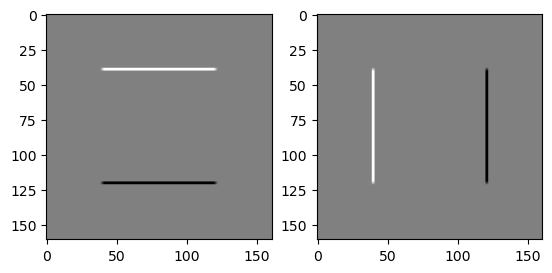

In [7]:
# Delete me for No Solutions
%matplotlib inline
square=np.load('square.npy')
h_m = np.asarray([[1, 1, 1],[0, 0, 0],[-1, -1, -1]],
                 dtype='float')/6.0
h_n = np.asarray([[1, 0, -1],[1, 0, -1],[1, 0, -1]], 
                 dtype='float')/6.0
gm = conv2(square,h_m,'same')
gn = conv2(square,h_n,'same')
fig,axs = plt.subplots(1,2)
axs[0].imshow(gm,cmap='gray')
axs[1].imshow(gn,cmap='gray')

Text(0.5, 1.0, 'square.npy')

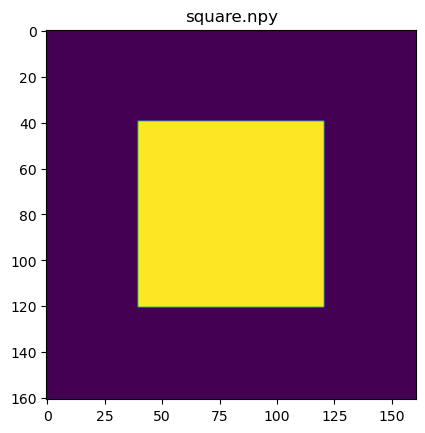

In [8]:
#plot original image
%matplotlib inline
import matplotlib.pyplot as plt
square=np.load('square.npy')
plt.imshow(square)
plt.axis('on')
plt.title('square.npy')

**Interlude**
To make sure you understand the result, it is sensible to either

 - display the image in an internal viewer, rather  than `inline`, then use the data cursor to investigate the values held in the image array OR 
 
 - plot a profile through the centre row of `gn` or the centre column of `gm` by using a command like this: `plt.plot(gn[80,:])`

#### 4.4.1 Plotting the gradient field

We can plot this field, but have to take a bit of care with a couple of things. First, plotting the field at _every_ pixel location will give us a very dense collection of vectors. The density of the vectors can sometimes make it very difficult to understand what is happening.

One of the tricks to avoid this problem is to _subsample_ the vector field, displaying it, say, only every 4 or 5 pixels. We also need to make sure that we create the coordinates of where these vectors are being calculated, passing those to the plotting command as well (known as a `quiver` plot). 

If we apply this to the image of the square we have just analysed, we obtain the following:

In [9]:
# Delete me after running for "no solutions" NB
square=np.load('square.npy')
h_m = np.asarray([[1, 1, 1],[0, 0, 0],[-1, -1, -1]],
                 dtype='float')/6.0
h_n = np.asarray([[1, 0, -1],[1, 0, -1],[1, 0, -1]], 
                 dtype='float')/6.0
gm = conv2(square,h_m,'same')
gn = conv2(square,h_n,'same')

Text(0.5, 1.0, 'Image and its gradient field')

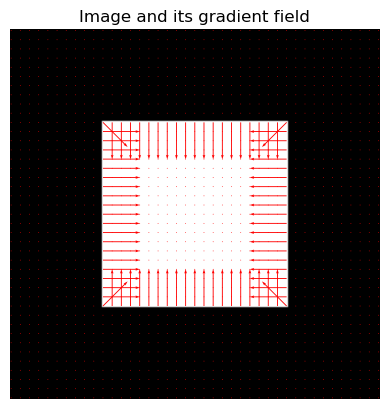

In [10]:
# Code snippet showing how to overlay gradient field
# onto the image from which it has been obtained
# Assumes that the supplied image "square"
# and the gradient field components "gm" and "gn"
# are already defined

M,N = np.shape(square)
skip = 4
xgrid = range(0,N)
ygrid = range(0,M)
x,y = np.meshgrid(xgrid,ygrid)
plt.imshow(square,cmap='gray')
plt.quiver(x[::skip,::skip],y[::skip,::skip],
           gn[::skip,::skip],
           -gm[::skip,::skip],
           color='r',
           scale=50)
plt.axis('off')
plt.title('Image and its gradient field')

#### 4.4.2 Magnitude of the gradient field

The directional nature of the gradient operators we have used gives us the ability to deduce not only the rate of change of intensity, but also the direction. The penalty we pay for this is that, if our goal is to detect the presence of intensity edges, we have to combine the information from both gradient masks.

To calculate the magnitude of the gradient field, we can take different approaches, but the one that is best in this case - since it provides almost uniform sensitivity with direction, is to compute the resultant of both components of the gradient field using the "standard" approach to calculating the magnitude of a vector (see also the lecture notes):

$$
|\boldsymbol\nabla f(m,n)| = \sqrt{g_m^2(m,n) + g_n^2(m,n)}
$$

where $g_m(m,n)$ and $g_n(m,n)$ are the components of the gradient fields, which come from the outputs of the respective convolutions. 

Doing this gives us the edge strength operator, the equivalent of the second to last line in the 1D calculation at the start of this NB:

Text(0.5, 1.0, 'Egde Strength')

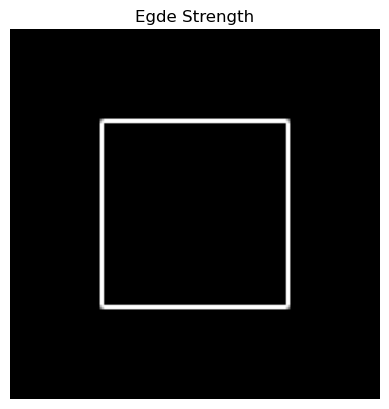

In [11]:
g = np.sqrt(gm**2 + gn**2)
plt.imshow(g, cmap='gray')
plt.axis('off')
plt.title('Egde Strength')

In [12]:
# Code to threshold (INCOMPLETE)
# g = np.sqrt(gm**2 + gn**2)
# g_thresh=[]
# T=50#Threshold value
# for x in g:
#     if x>T:
#         g_thresh.append(x)
#     else:
#         g_thresh.append(0)
# plt.imshow(g_thresh, cmap='gray')
# plt.axis('off')
# plt.title('Egde Strength')





The edge strength output can be thresholded to produce a binary edge map. The thickness of the edge map will depend on where the threshold is set, and the profile of the gradient strength result. It is **not** an edge map itself, as we have not applied any thresholding. Even though it sort of looks like one...

<div style="background:#EEEEFF;color:black">
    
**Exercise 4.5**

You are given a test image stored in the file 
`circle.npy` with this notebook; apply the gradient masks to this image to estimate the two gradient components. Display the components separately as images, with a grey scale colour map, and then plot the gradient field overlaid on the circle.
    
</div>

Text(0.5, 1.0, 'circle.npy')

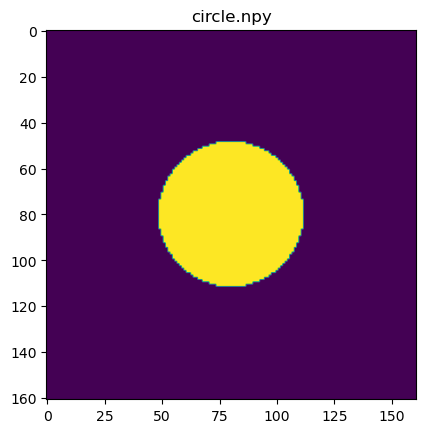

In [13]:
#plot original image
%matplotlib inline
import matplotlib.pyplot as plt
circle=np.load('circle.npy')
plt.imshow(circle)
plt.axis('on')
plt.title('circle.npy')

<details>
    <summary> Click <b> here </b> for the answer to <b>Ex. 4.5</b> </summary>

```python

circle=np.load('circle.npy')
h_m = np.asarray([[1, 1, 1],[0, 0, 0],[-1, -1, -1]],
                 dtype='float')/6.0
h_n = np.asarray([[1, 0, -1],[1, 0, -1],[1, 0, -1]], 
                 dtype='float')/6.0
gm = conv2(circle,h_m,'same')
gn = conv2(circle,h_n,'same')
fig,axs = plt.subplots(1,2)
axs[0].imshow(gm,cmap='gray')
axs[1].imshow(gn,cmap='gray')
    

```

Then, for the vector field plot:

```python
    
M,N = np.shape(circle)
skip = 4
xgrid = range(0,N)
ygrid = range(0,M)
x,y = np.meshgrid(xgrid,ygrid)
plt.imshow(circle,cmap='gray')
plt.quiver(x[::skip,::skip],y[::skip,::skip],
           gn[::skip,::skip],
           -gm[::skip,::skip],
           color='r',
           scale=50)
plt.axis('off')
    
```
    
</details>

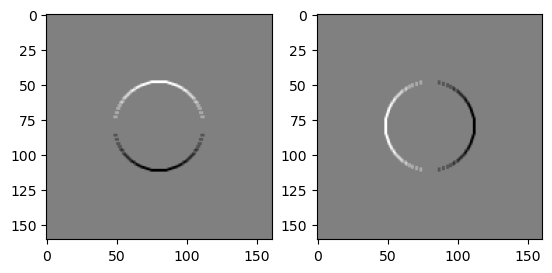

In [16]:
# Delete me for No Solutions
circle=np.load('circle.npy')
h_m = np.asarray([[1, 1, 1],[0, 0, 0],[-1, -1, -1]],
                 dtype='float')/6.0
h_n = np.asarray([[1, 0, -1],[1, 0, -1],[1, 0, -1]], 
                 dtype='float')/6.0
gm = conv2(circle,h_m,'same')
gn = conv2(circle,h_n,'same')
fig,axs = plt.subplots(1,2)
axs[0].imshow(gm,cmap='gray')
axs[1].imshow(gn,cmap='gray')

(-0.5, 160.5, 160.5, -0.5)

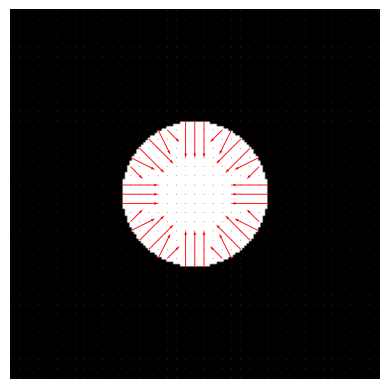

In [17]:
# Delete me for No Solutions
M,N = np.shape(circle)
skip = 4
xgrid = range(0,N)
ygrid = range(0,M)
x,y = np.meshgrid(xgrid,ygrid)
plt.imshow(circle,cmap='gray')
plt.quiver(x[::skip,::skip],y[::skip,::skip],
           gn[::skip,::skip],
           -gm[::skip,::skip],
           color='r',
           scale=5)
plt.axis('off')

<div class="alert alert-warning">
    
Remember: the gradient magnitude calculation is just that: it is *not* an edge map, as we have not applied a decision process (thresholding) to decide where an edge is. 
    
Sometimes, Prewitt and similar gradient masks are referred to as edge-detection masks. This is **wrong**. They are gradient estimation masks. What you do with the calculations after generating the gradient field component images may lead to edge detection, but that is a distinct process. To make sure you understand this, please return to the one-dimensional example at the start of this Notebook.

</div>

### 4.5 Applying Gaussian blur

Applying blurring functions may used for several reasons, and one can be thought of as a simple technique of denoising or data conditioning. Even in the case of the nice clean images we are using here, there can be irregularity in results due to the presence of the discrete representations that are being used. Check out the direction of the arrows on the circle: the gradient field is beig affected by the pixellated appearance of the image.

We will generate a simple 2D Gaussian and apply it to the image data, then consider the gradient field that we get. To start with, note that the isotropic 2D Gaussian, centered on (0,0) can be defined with this Equation:

$$
G(x,y;\sigma) = \frac{1}{2\pi \sigma^2}\exp \left \lbrace
-\frac{x^2+y^2}{2\sigma^2} \right \rbrace \,\,\,\,\, Eq. (E)
$$

The multiplier of $\frac{1}{2\pi \sigma^2}$ is a normalising constant that depends on the width $\sigma$ parameter of the Gaussian, also called its scale. The normalising constant makes the 2D integral of the Gaussian equal to 1.

When trying to build this function, there are different approaches, including repeated application of the approximate  mask discussed in the lecture notes, but doing that makes the value of $\sigma$ hard to set exactly.

We can also create a 2D Gaussian mask easily by sampling Eq. (E) on a discrete grid. We will use the `meshgrid` command to do this. However, there are also some tricks to remember when doing this.

1. The size of the meshgrid used to make an approximate Gaussian should be dependent on the value of $\sigma$. Otherwise, you won't get a good approximation to the smooth characteristics of the Gaussian.

2. The normalising constant should be included in the spatial sampling of Eq (E), but may be a bit off, partly because of finite-sized nature of the spatial sampling (the Gaussian extends to infinity, the convolution mask should be finite in size), but also because when we apply the Gaussian by discrete 2D convolution, we want the _sum_ of the values in the Gaussian mask to be 1.

To address Point 1, we need the mask to be sufficiently large. A good suggestion is to use a grid of width at least 5 times the value of $\sigma$. To address Point 2, it is sometimes a good idea to renormalise the mask by the sum of the elements.

In [20]:
# I've chosen a value for sigma, sort of at random 
sigma=3
# This makes a 2D coordinate system
# I suggest checking the shapes/values of x and y
x,y = np.meshgrid(range(-7,8),range(-7,8))

# This is essentially radius squared
rsquared = x**2+y**2
# Gaussian is computed below
Gauss = np.exp(-rsquared/(2*sigma**2))/(2*np.pi*sigma**2)

# May sometimes be useful to do this
Gauss = Gauss/np.sum(Gauss)

# Visualising the Gaussian
plt.imshow(Gauss)

I find the alternative visualisation helpful in interpreting the
Gaussian as a smoothing function....

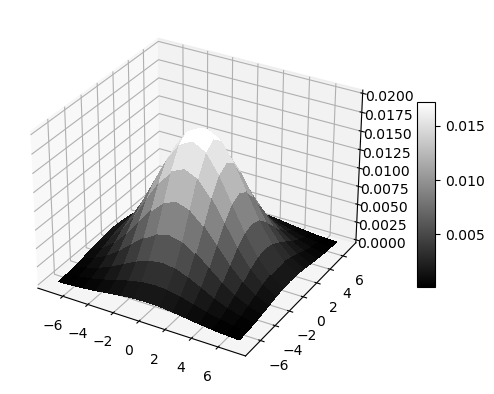

In [22]:
# Here is an alternative visualisation; this reminds 
# us that this is just a two dimensional function that smooths
# the data
%matplotlib inline
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
X = x
Y = y

surf = ax.plot_surface(X, Y, Gauss,
                       linewidth=0, antialiased=False, cmap='gray')
ax.set_zlim(0, 0.02)
fig.colorbar(surf, shrink=0.5, aspect=10)

<div style="background:#EEEEFF;color:black">
    
**Exercise 4.6**

Redo the gradient vector field plot of the circle, but this time, blur the circle image first with a Gaussian with a $\sigma$ of 3. This is sometimes described as _regularising_ the gradient calculation. Can you see any difference in the arrow directions? Note that you should use the `"same"` option for the convolution.

NB: I recommend plotting in the external viewer if you can, using the `%matplotlib` directive; inline, you may get some artefacts.
    
</div>

<details>
    <summary> Click <b>here</b> for one possible answer to <b>Ex. 4.6</b>
</summary>
    
```python
%matplotlib inline
circle=np.load('circle.npy')
blurredcircle = conv2(circle,Gauss,'same')
h_m = np.asarray([[1, 1, 1],[0, 0, 0],[-1, -1, -1]],
                 dtype='float')/6.0
h_n = np.asarray([[1, 0, -1],[1, 0, -1],[1, 0, -1]], 
                 dtype='float')/6.0
gm = conv2(blurredcircle,h_m,'same')
gn = conv2(blurredcircle,h_n,'same')

M,N = np.shape(blurredcircle)
skip = 4
xgrid = range(0,N)
ygrid = range(0,M)
x,y = np.meshgrid(xgrid,ygrid)
plt.imshow(circle,cmap='gray')
plt.quiver(x[::skip,::skip],y[::skip,::skip],
           gn[::skip,::skip],
           -gm[::skip,::skip],
           color='r',
           scale=2)
plt.axis('off')
```
    
</details>

(-0.5, 160.5, 160.5, -0.5)

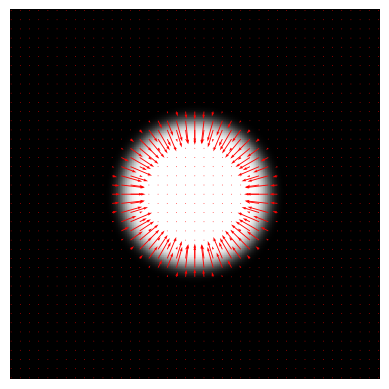

In [18]:
# Delete me for No Solutions
%matplotlib inline
circle=np.load('circle.npy')
blurredcircle = conv2(circle,Gauss,'same')
h_m = np.asarray([[1, 1, 1],[0, 0, 0],[-1, -1, -1]],
                 dtype='float')/6.0
h_n = np.asarray([[1, 0, -1],[1, 0, -1],[1, 0, -1]], 
                 dtype='float')/6.0
gm = conv2(blurredcircle,h_m,'same')
gn = conv2(blurredcircle,h_n,'same')

M,N = np.shape(blurredcircle)
skip = 4
xgrid = range(0,N)
ygrid = range(0,M)
x,y = np.meshgrid(xgrid,ygrid)
plt.imshow(blurredcircle,cmap='gray')
plt.quiver(x[::skip,::skip],y[::skip,::skip],
           gn[::skip,::skip],
           -gm[::skip,::skip],
           color='r',
           scale=2)
plt.axis('off')

### 4.6 Learning Outcomes

1. Appreciating the difference between linear and non-linear operations in edge detection. It is often found that the Prewitt, or similar, masks are called _edge detection_ masks. But they are **not**, and there is no such thing. The masks, applied by convolution, provide _gradient estimates_.

2. Appreciating in a concrete way the steps required to go from a signal (or image) to a measure of gradient strength, and then applying a decision process to create an edge map.

3. Understanding how a derivative operation can be approximated by a finite difference operation, which is really easy to understand!

4. Appreciating that the finite difference operator can be implemented by one dimensional convolution.

5. Getting some confidence in how to interpret the 1D convolution expression, by unravelling the summation into a series of terms.

6. Reminding ourselves that convolution enables flexibility in implementing linear operators: just change the convolution mask to perform a different type of linear neighbourhood operation.

7. Understanding that results of applying a pair of gradient estimation convolution masks is a pair of scalar fields that can be represented as a vector field.

8. Understanding how to approximate a Gaussian convolution by sampling the equation of a continuous Gaussian, and paying attention to a couple of details.

AAB